In [70]:
import pandas as pd
from collections import Counter, defaultdict
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import umap
%matplotlib inline
datafile = 'dataset2.count.txt'
df = pd.read_csv(datafile, sep='\t')

In [71]:
df = df.set_index('Gene.Symbol')
cells = list(df.columns.values)

In [64]:
mat = np.array(df)
per_cell_sum = mat.sum(axis=1)
per_gene_sum = mat.sum(axis=0)
low_expr_thr = 100
high_expr_thr = 1000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
mat = mat[:, CV >= 1.5]
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
mat = np.log(mat+1)
#df = pd.DataFrame(mat,index=mat[:,0])

In [43]:
def dendrogrammer(df, leaf_labels):
    D = df.values
    if len(leaf_labels) != len(D):
        D = np.transpose(D)
    Z = linkage(D, method='ward', metric='euclidean')
    plt.figure(figsize=(10, 10))
    ax = plt.subplot()
    plt.subplots_adjust(left=0.07, bottom = 0.3, right = 0.98, top = 0.95, wspace=0, hspace=0)
    plt.xlabel('Cell Line')
    plt.ylabel('Distance')
    
    dendrogram(Z, leaf_rotation=90., leaf_font_size=10., labels = leaf_labels)
    plt.savefig('dendrogram_nci60.png')

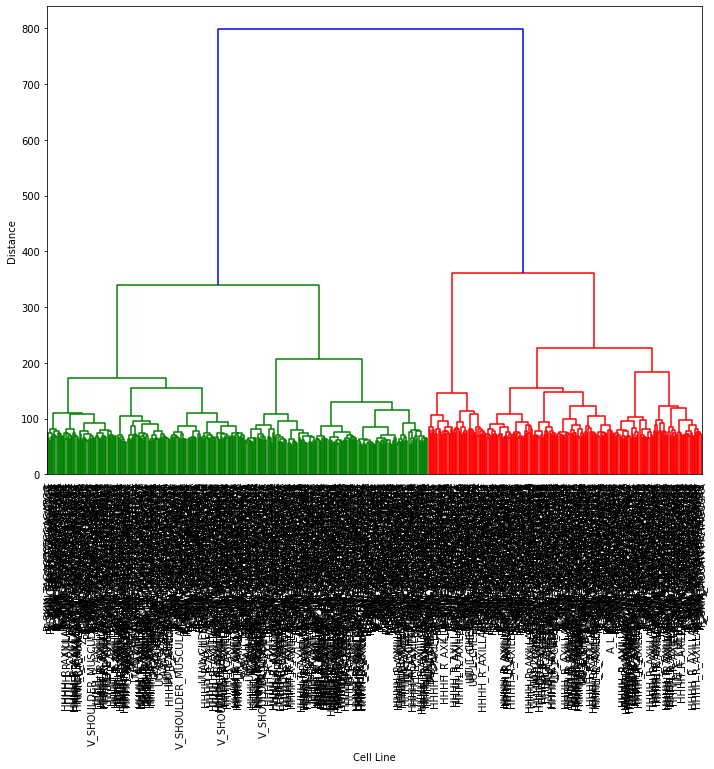

In [179]:

dendrogrammer(df, cells)

In [72]:
def PCAer(df):
     D = df.values
     D = np.transpose(D)
     pca = PCA(n_components= 50)
     pca.fit(D)
     projected = pca.fit_transform(D)
     return projected

In [73]:
from sklearn.cluster import KMeans
Dpc = PCAer(df)
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(Dpc)
labels = kmeans.predict(Dpc)
C = kmeans.cluster_centers_
out = [Dpc, labels, C]
print(np.bincount(kmeans.labels_))
'''
def kmeanser(df, k): 
    Dpc = PCAer(df)
    kmeans = KMeans(n_clusters=3)
    kmeans = kmeans.fit(Dpc)
    labels = kmeans.predict(Dpc)
    C = kmeans.cluster_centers_
    out = [Dpc, labels, C]
    print(np.bincount(kmeans.labels_))
    return out
'''
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def ClusterIndicesComp(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

[ 38 390 198]


In [74]:
num1 = ClusterIndicesNumpy(0, kmeans.labels_)
num2 = ClusterIndicesNumpy(1, kmeans.labels_)
num3 = ClusterIndicesNumpy(2, kmeans.labels_)
barcodes1 = []
barcodes2 = []
barcodes3 = []
for i in num1:
    barcodes1.append(cells[i])
for i in num2:
    barcodes2.append(cells[i])
for i in num3:
    barcodes3.append(cells[i])
with open('1cluster.txt', 'w') as filehandle:
    for listitem in barcodes1:
        filehandle.write('%s\n' % listitem)
with open('2cluster.txt', 'w') as filehandle:
    for listitem in barcodes2:
        filehandle.write('%s\n' % listitem)
with open('3cluster.txt', 'w') as filehandle:
    for listitem in barcodes3:
        filehandle.write('%s\n' % listitem)
g1 = open('G1Cells.txt').readlines()
g1_line = []
for lines in g1:
    g1_line.append(lines)
g2m = open('G2MCells.txt').readlines()
g2m_line = []
for lines in g2m:
    g2m_line.append(lines)
s = open('SCells.txt').readlines()
s_line = []
for lines in s:
    s_line.append(lines)
cluster1 = open('1cluster.txt').readlines()
cluster1_line = []
g1count = 0
g2mcount = 0
scount = 0
for lines in cluster1:
    cluster1_line.append(lines)
for i in cluster1_line:
    for j in g1_line:
        if i == j:
            g1count = g1count + 1
print("G1 Count:")
print(g1count/(len(cluster1_line)))

for i in cluster1_line:
    for j in g2m_line:
        if i == j:
            g2mcount = g2mcount + 1
print("G2M Count:")
print(g2mcount/(len(cluster1_line)))

for i in cluster1_line:
    for j in s_line:
        if i == j:
            scount = scount + 1
print("S Count:")
print(scount/(len(cluster1_line)))
'''
file1 = open('cluster_001.txt').readlines()
file1_line = []
for lines in file1:
     file1_line.append(lines)
file2 = open('cluster_00001.txt').readlines()
file2_line = []
count = 0
for lines in file2:
     file2_line.append(lines)
if len(file1) > len(file2):
    for i in range(0, len(file2)):
        if file1[i] == file2[i]:
            count = count + 1
    print(count/len(file1))
else:
    for i in range(0, len(file1)):
        if file2[i] == file1[i]:
            count = count + 1
    print(count/len(file2))
'''
[proj, labels, centroids] = out

G1 Count:
0.10526315789473684
G2M Count:
0.47368421052631576
S Count:
0.42105263157894735


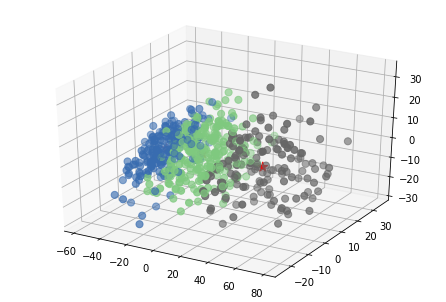

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1 = Axes3D(fig1)

ax1.scatter(proj[:,0], proj[:, 1], proj[:, 2], c=labels, s=50, cmap='Accent')

ax1.scatter(centroids[:,0], centroids[:, 1], centroids[:,2], c = 'red', s=100, marker='*', cmap='Accent')


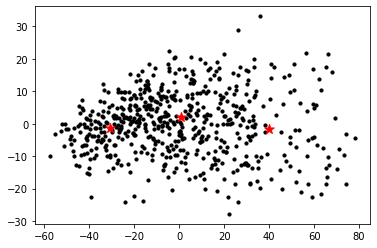

In [17]:
plt.scatter(proj[:,0], proj[:,2], s=10.0, color='black')
plt.scatter(centroids[:,0], centroids[:, 2], c = 'red', s = 100, marker='*', cmap='Accent')

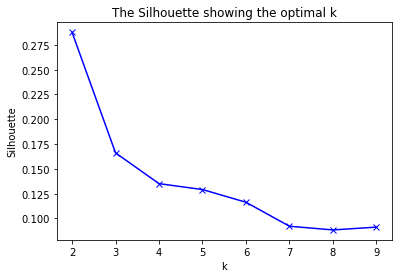

In [18]:
from sklearn.metrics import silhouette_score
K = range(2, 10)
sil = []
Dpc = PCAer(df)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(Dpc)
    labels = kmeans.predict(Dpc)
    sil.append(silhouette_score(Dpc, labels))
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('The Silhouette showing the optimal k')
plt.show()

In [381]:
from scipy.spatial.distance import cdist
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    kmeanModel.fit(df)
    #distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis = 1))/df.shape[0])
    distortions.append(kmeanModel.inertia_)
print(distortions)

[4261452.850400253, 2609587.3986792946, 2072151.2291102142, 1842446.972326549, 1727576.3063238966, 1674567.6291417652, 1638910.5319379584, 1612116.3121806663, 1595880.7312405473]


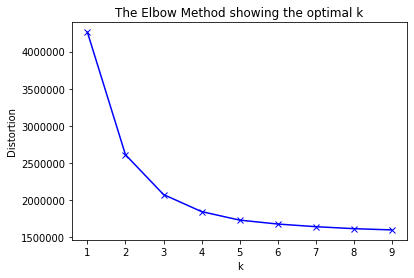

In [380]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()